# 개, 고양이 분류

## 텐서플로우를 이용한 이미지 분류

# 1. 데이터 수집

## a. 라이브러리 및 데이터 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
np.random.seed(100)
tf.random.set_seed(100)

In [2]:
train_dir = r"E:\image_data\cats_dogs\split\train"
test_dir = r"E:\image_data\cats_dogs\split\test"
val_dir = r"E:\image_data\cats_dogs\split\val"

<br>
<br>

### ImageDataGenerator 를 사용하여 이미지의 수를 증가시킵니다.

In [3]:
train_datagen = ImageDataGenerator(rescale=1.0/255., # 픽셀 값을 0 ~ 1로 설정합니다.
                                   rotation_range=40, # 이미지의 회전을 줍니다.
                                   width_shift_range=0.2, # 이미지를 수평 수직으로 랜덤하게 움직이도록 설정합니다.
                                   height_shift_range=0.2, 
                                   shear_range=0.2, # 시계 반대 방향으로 밀림 강도 범위 내에서 랜덤하게 이미지를 변형합니다.
                                   zoom_range=0.2, # 이미지를 확대 축소합니다.
                                   horizontal_flip=True, # 이미지를 수평방향으로 뒤집습니다.                                   
                                   )
val_datagen = ImageDataGenerator(rescale=1.0/255.,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,                                    
                                 )
test_datagen = ImageDataGenerator(rescale=1.0/255.)

### flow_from_directory를 사용하여 이미지를 불러온 뒤 rescaling을 적용하여 이미지를 resize 합니다.

In [4]:
train_ds = train_datagen.flow_from_directory(train_dir, 
                                            class_mode='binary', # 이진 분류의 클래스 모드를 설정합니다.
                                            target_size=(150,150), # 이미지의 크기를 설정합니다.
                                            batch_size=32) # 데이터의 크기를 지정합니다.

val_ds = val_datagen.flow_from_directory(val_dir,
                                            class_mode='binary',
                                            target_size=(150,150),
                                            batch_size=32)

test_ds = test_datagen.flow_from_directory(test_dir,
                                            class_mode='binary',
                                            target_size=(150,150),
                                            batch_size=32)

Found 4786 images belonging to 2 classes.
Found 1846 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [5]:
# 배치 개수만큼 이미지 조회
batch = train_ds.next()

In [6]:
len(batch), type(batch)

(2, tuple)

In [7]:
type(batch[0]), batch[0].shape

(numpy.ndarray, (32, 150, 150, 3))

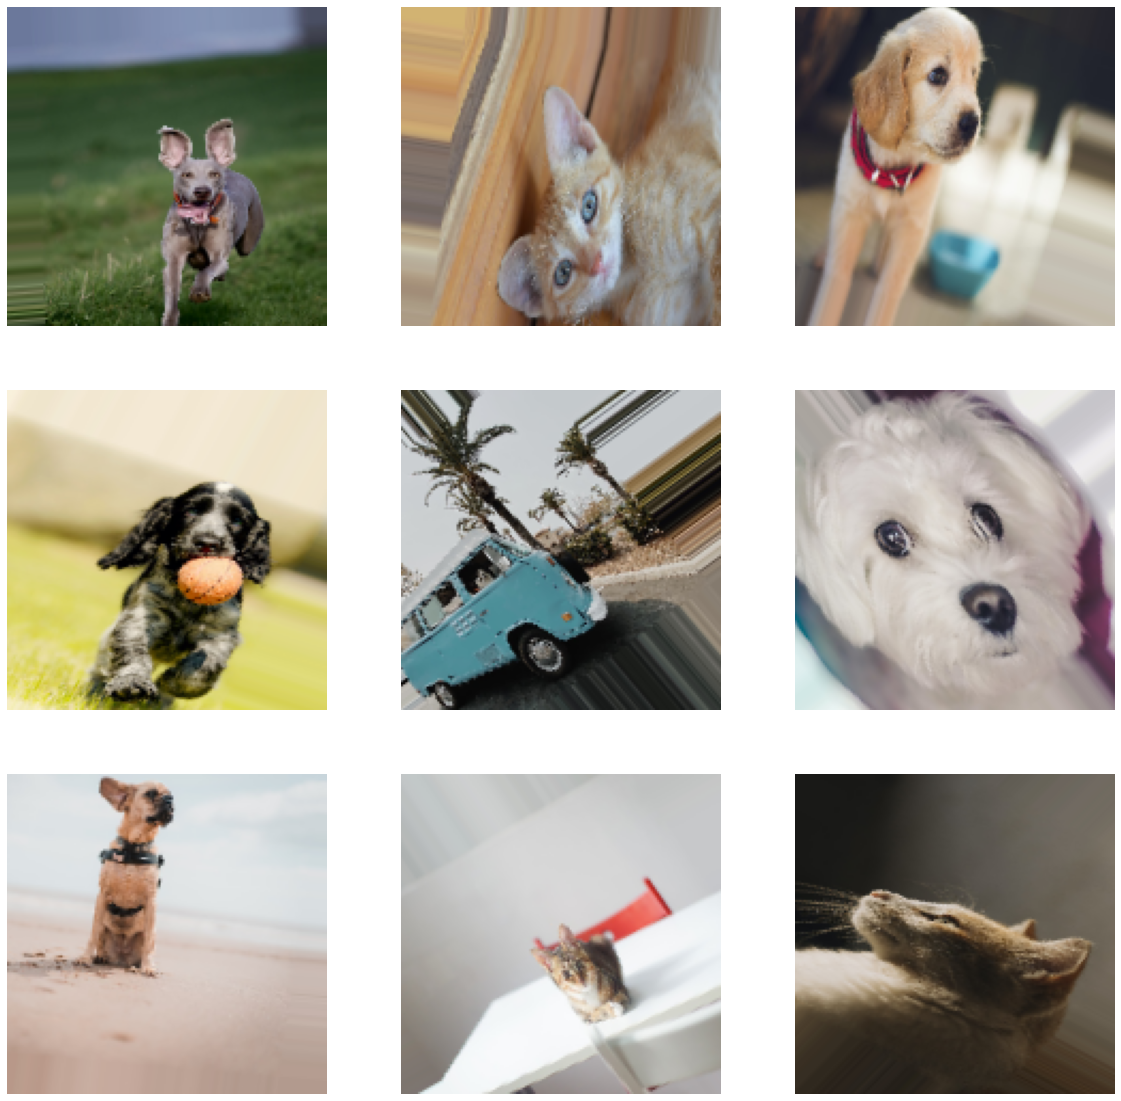

In [8]:
# 이미지 확인
plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(batch[0][i]),
    plt.axis('off')
plt.show()

In [9]:
# 학습에 사용할 모델을 정의합니다.
def create_model():
    model = keras.Sequential()
    # 이미지 특징 추출 
    model.add(keras.layers.Conv2D(32, 
                                  kernel_size=3, # 3x3 픽셀
                                  padding='same', # 샘플 테두리 설정
                                  activation='relu', # 활성화 함수를 설정합니다.
                                  input_shape=(150,150,3))) # 이미지의 크기 및  컬러 이미지의 채널을 설정합니다.
    model.add(keras.layers.MaxPool2D(padding='same'))
   
    model.add(keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPool2D(padding='same'))

    model.add(keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPool2D(padding='same'))

    model.add(keras.layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPool2D(padding='same'))
    
    # 이미지 분류 
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.5)) # 50%를 버립니다. 
    model.add(keras.layers.Dense(512, activation='relu'))
    
    # 출력
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    return model

In [10]:
cp = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', verbose=1) # 최적의 학습 모델을 찾으면 자동으로 저장합니다.
es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) # 최적의 학습 모델을 찾으면 자동으로 학습으로 조기종료합니다.

In [11]:
# 모델 생성, 컴파일
model = create_model()
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), # 학습률 설정
              loss='binary_crossentropy', # 이진분류 
              metrics=['accuracy']) # 정확성을 기준으로 확인

In [12]:
# 모델의 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 256)       2

In [13]:
# 모델 학습
history = model.fit(train_ds, epochs=100,# 100회 반복하며 학습을 진행(100회 전 최적의 값을 찾으면 조기종료)
                    steps_per_epoch=150,  
                    validation_data=val_ds, 
                    validation_steps=55, 
                    callbacks=[cp,es], # 저장 및 조기종료
                    shuffle=True 
                    )

Epoch 1/100
150/150 [==============================] - 209s 1s/step - loss: 0.7791 - accuracy: 0.5305 - val_loss: 0.6859 - val_accuracy: 0.5165

Epoch 00001: saving model to best-cnn-model.h5
Epoch 2/100
150/150 [==============================] - 214s 1s/step - loss: 0.6906 - accuracy: 0.5702 - val_loss: 0.6861 - val_accuracy: 0.5403

Epoch 00002: saving model to best-cnn-model.h5
Epoch 3/100
150/150 [==============================] - 213s 1s/step - loss: 0.6818 - accuracy: 0.5846 - val_loss: 0.6535 - val_accuracy: 0.6256

Epoch 00003: saving model to best-cnn-model.h5
Epoch 4/100
150/150 [==============================] - 215s 1s/step - loss: 0.6732 - accuracy: 0.6101 - val_loss: 0.6573 - val_accuracy: 0.6244

Epoch 00004: saving model to best-cnn-model.h5
Epoch 5/100
150/150 [==============================] - 215s 1s/step - loss: 0.6519 - accuracy: 0.6379 - val_loss: 0.6400 - val_accuracy: 0.6358

Epoch 00005: saving model to best-cnn-model.h5
Epoch 6/100
150/150 [===================

In [14]:
# 검증셋 평가
# loss 43%, acc 79%
model.evaluate(val_ds)

58/58 [==============================] - 61s 1s/step - loss: 0.4337 - accuracy: 0.7952


[0.43370142579078674, 0.7952329516410828]

In [18]:
# 테스트셋 평가
# loss 40%, acc 83%
model.evaluate(test_ds)

16/16 [==============================] - 16s 1s/step - loss: 0.4074 - accuracy: 0.8300


[0.4074208438396454, 0.8299999833106995]

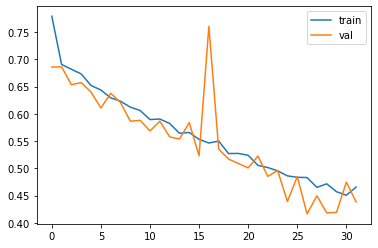

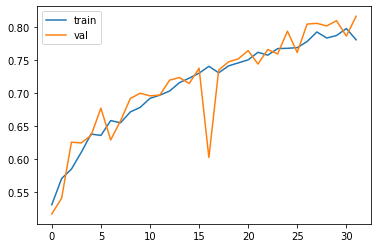

In [15]:
# 손실값 그래프 출력
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

# 정확도 그래프 출력
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()